RSNL not converging ... do some tests on why

# suspect 1: use full cov matrix?

In [28]:
import os
import pickle as pkl
import jax.random as random
from flowjax.bijections import RationalQuadraticSpline  # type: ignore
from flowjax.distributions import StandardNormal  # type: ignore
from flowjax.flows import CouplingFlow  # type: ignore
from flowjax.train.data_fit import fit_to_data  # type: ignore
from jax._src.prng import PRNGKeyArray  # for typing
from numpyro.infer import MCMC, NUTS  # type: ignore

import jax.numpy as jnp
import numpy as np
import torch

from mm_sbi_review.examples.earthquake import earthquake_sim_fn_4_param, sum_fn, early_return
from mm_sbi_review.scripts.utils import download_file, extract_tar_gz, combine_ascii_files

import pandas as pd
from shapely.geometry import Polygon
import geopandas as gpd
from numpyro.distributions import Gamma, Uniform, Independent


In [29]:
np.random.seed(123)
torch.manual_seed(321)
# true_mu = 1.58e-06
# true_alpha = 1.3
# true_k = 0.0025
# true_c = 0.003
# true_p = 1.05  # or 0.66 or 1.05

# true_mu = 2e-05
# true_k = 0.2
# true_c = 0.5
# true_p = 1.5

# true_params = {'log10_mu': np.log10(true_mu), 'log10_k0': np.log10(true_k),
#             #    'a': true_alpha,
#                 'log10_c': np.log10(true_c), 'rho': true_p}
# TODO: first - set up simulator to take in parameters
# TODO: SNPE
# TODO: Priors
# beta = 2.302585092994046
# beta = 2.4
url = "https://scedc.caltech.edu/ftp/catalogs/SCEC_DC/SCEDC_catalogs.tar.gz"
local_filename = "SCEDC_catalogs.tar.gz"
extract_path = "./"

# Download and extract the file
download_file(url, local_filename)
extract_tar_gz(local_filename, extract_path)
combine_ascii_files('./raw')
raw_catalog = pd.read_csv("raw/SCEDC_catalog.csv")
raw_catalog['time'] = pd.to_datetime(raw_catalog['time'])
raw_catalog = raw_catalog.sort_values(by='time')
raw_catalog = raw_catalog[["time", "longitude", "latitude","magnitude"]].dropna()
raw_catalog.reset_index(drop=False, inplace=True)

polygon_coords = np.load('../data/SCEDC_shape.npy')

poly = Polygon(polygon_coords)
gdf = gpd.GeoDataFrame(
    raw_catalog,
    geometry=gpd.points_from_xy(
        raw_catalog.latitude, raw_catalog.longitude),)

catalog = gdf[gdf.intersects(poly)].copy()
catalog.drop("geometry", axis=1, inplace=True)
len_trunc_x = len(catalog)
print('Removed',len(raw_catalog)-len_trunc_x, 'events outside polygon')

# filter events within timewindow
auxiliary_start = '1985-01-01 00:00:00'
test_nll_end = '2014-01-11 00:00:00'
catalog = catalog[catalog['time']>=auxiliary_start]
catalog = catalog[catalog['time']<test_nll_end]
len_trunc_t = len(catalog)
print('Removed',len_trunc_x-len_trunc_t, 'events outside timewindow')

M_cut = 3.0
catalog = catalog[catalog['magnitude']>=M_cut]
len_trunc_m = len(catalog)
print('Removed',len_trunc_t-len_trunc_m, 'events below Mcut')

x_obs = sum_fn(catalog)


Downloaded SCEDC_catalogs.tar.gz
Extracted to ./
final file shape:  (890615, 12)
Merged dataset saved successfully as a CSV file.
Removed 0 events outside polygon
Removed 365809 events outside timewindow
Removed 514852 events below Mcut
Kvals[0]:  0.09765982507406056


In [30]:
with open('../res/earthquake_4_param/thetas_all_round_1.pkl', 'rb') as f:
    thetas_all = pkl.load(f)
    
with open('../res/earthquake_4_param/x_sims_all_round_1.pkl', 'rb') as f:
    x_sims_all = pkl.load(f)
    
# standardize the data
theta_dims = 5
summary_dims = 39

standardisation_params = {
    'theta_mean': jnp.empty(theta_dims),
    'theta_std': jnp.empty(theta_dims),
    'x_sims_mean': jnp.empty(summary_dims),
    'x_sims_std': jnp.empty(summary_dims)
}

# standardise simulated summaries
standardisation_params['x_sims_mean'] = jnp.mean(x_sims_all, axis=0)
standardisation_params['x_sims_std'] = jnp.std(x_sims_all, axis=0)
x_sims_all_standardised = (x_sims_all - standardisation_params['x_sims_mean']) / standardisation_params['x_sims_std']
x_obs_standard = (x_obs - standardisation_params['x_sims_mean']) / standardisation_params['x_sims_std']

# standardise parameters
standardisation_params['theta_mean'] = jnp.mean(thetas_all, axis=0)
standardisation_params['theta_std'] = jnp.std(thetas_all, axis=0)

thetas_all_standardised = (thetas_all - standardisation_params['theta_mean']) / standardisation_params['theta_std']
x_obs_standard = (x_obs - x_sims_all.mean(axis=0)) / x_sims_all.std(axis=0)
x_sims_all_standardised.shape


(3000, 39)

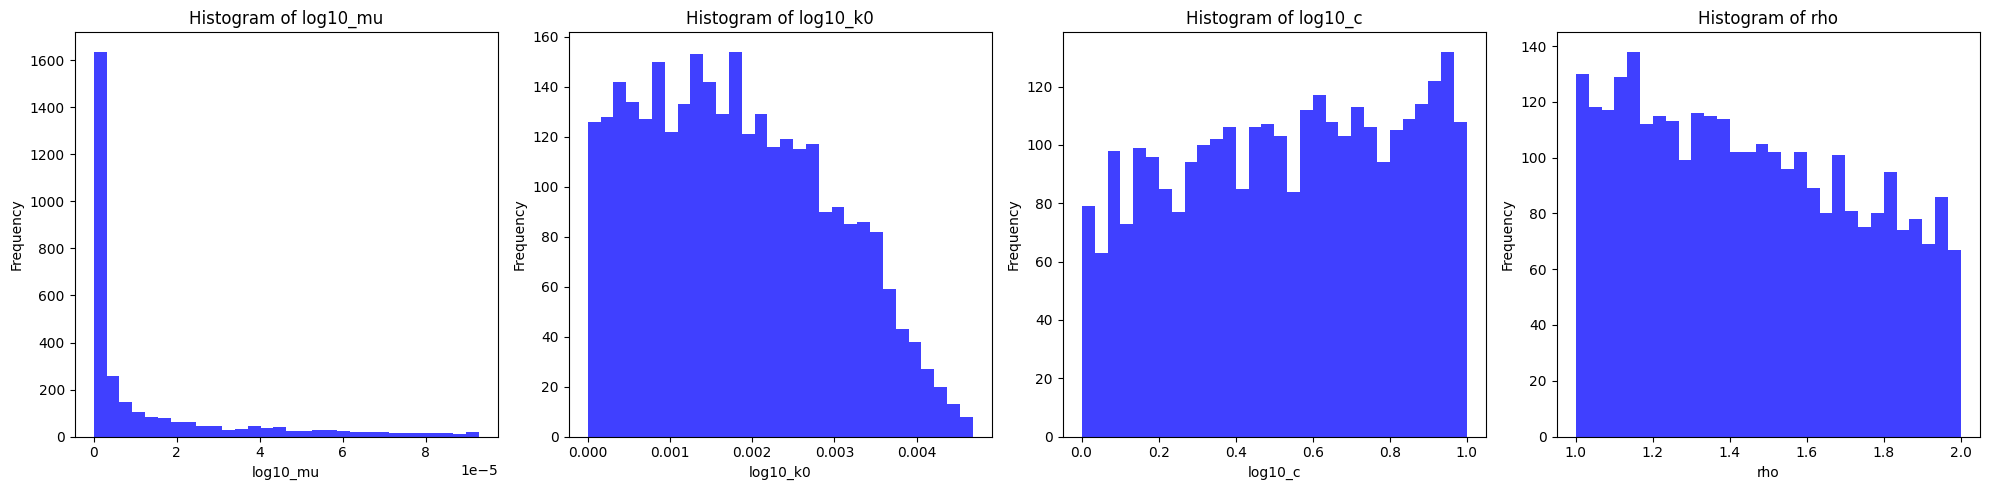

In [31]:
import matplotlib.pyplot as plt

# Plot histograms for each parameter in thetas_all
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

theta_labels = ['log10_mu', 'log10_k0', 'log10_c', 'rho']
for i, ax in enumerate(axes):
    ax.hist(thetas_all[:, i], bins=30, alpha=0.75, color='blue')
    ax.set_title(f'Histogram of {theta_labels[i]}')
    ax.set_xlabel(theta_labels[i])
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../res/earthquake_4_param/histograms_theta.png')
plt.show()

In [32]:
summary_dims = x_sims_all_standardised.shape[1]
x_sims_all.shape

(3000, 39)

In [33]:
rng_key = random.PRNGKey(1)
rng_key, sub_key = random.split(rng_key)
flow = CouplingFlow(
    key=sub_key,
    base_dist=StandardNormal((summary_dims,)),
    transformer=RationalQuadraticSpline(knots=10, interval=5),  # 10 spline segments over [-5, 5].
    cond_dim=thetas_all_standardised.shape[1],
    flow_layers=5,
    nn_width=50
    )

rng_key, sub_key = random.split(rng_key)
flow, losses = fit_to_data(key=sub_key,
                            dist=flow,
                            x=x_sims_all_standardised,
                            condition=thetas_all_standardised,
                            max_epochs=500,
                            max_patience=20,
                            batch_size=256  #  TODO! CHANGE BACK 256
                            )


 76%|███████▋  | 382/500 [02:41<00:49,  2.37it/s, train=-84.2, val=-79.6 (Max patience reached)]


In [34]:
# samples = flow.sample(rng_key, (10,), thetas_all_standardised)

MCMC 

In [35]:
from rsnl.model import get_robust_model
from numpyro.infer.initialization import init_to_mean, init_to_median, init_to_sample, init_to_value

In [36]:
import json

def valid_fn(thetas):
    with open("../data/config/SCEDC_30.json", 'r') as f:
        simulation_config = json.load(f)
    catalog_params = simulation_config["theta_0"].copy()
    if len(thetas) == 5:
        mu, a, k0, c, rho = thetas
    if len(thetas) == 4:
        mu, k0, c, rho = thetas
        a = simulation_config["beta"]

    try:
        params_dict = dict(
            {
                'log10_mu': np.log10(mu),
                'log10_k0': np.log10(k0),
                'a': np.array(a),
                'log10_c': np.log10(c),
                'rho': rho
            }
        )  # Attempt conversion
        params_dict["a"] = params_dict["a"].item()
        params_dict['rho'] = params_dict['rho'].item()
    except Exception as e:
        print(e)

    catalog_params.update(params_dict)

    # shape_coords = "data/input_data/california_shape.npy"  # used to be simulation_config["shape_coords"]

    # np.random.seed(777)
    # Note: in four param model version, alpha ("a") fixed to beta
    if "a" not in catalog_params:
        catalog_params["a"] = simulation_config["beta"]

    if early_return(catalog_params, simulation_config["beta"]):
        return False
    else:
        return True


In [37]:
def custom_init_to_valid_multiple_chains(prior, rng_key, num_chains=1, max_tries=5000):
    """Generate valid draws for multiple chains by repeatedly sampling from the prior."""
    thetas = []
    for _ in range(num_chains):
        for _ in range(max_tries):
            rng_key, subkey = random.split(rng_key)
            theta_candidate = np.array(prior.sample(subkey))
            if valid_fn(theta_candidate):
                thetas.append(theta_candidate)
                break
        else:
            raise RuntimeError(f"Could not find a valid draw in {max_tries} tries.")
    return jnp.array(thetas, dtype=jnp.float32)


In [38]:

import jax.numpy as jnp
from numpyro.distributions import Uniform, Gamma, Independent, Distribution
from numpyro.distributions.util import clamp_probs
from numpyro.distributions import constraints


# Define the Gamma prior for mu
mu_prior = Gamma(concentration=0.1, rate=10)

# Define the Uniform priors for the remaining parameters
other_priors = Uniform(
    low=jnp.array([0.0, 0.0, 1.0]),
    high=jnp.array([1.0, 1.0, 2.0])
)

# Combine the priors into a joint distribution
class CustomPrior(Distribution):
    support = constraints.real_vector
    def sample(self, key, sample_shape=()):
        mu_sample = mu_prior.sample(key, sample_shape)
        other_samples = other_priors.sample(key, sample_shape)
        return jnp.concatenate([mu_sample[..., None], other_samples], axis=-1)

    def log_prob(self, value):
        if value.ndim == 0:
            # Handle scalar case directly
            mu_log_prob = mu_prior.log_prob(value)
            other_log_prob = 0.0  # No other parameters to account for
        else:
            # Expected case for vector inputs
            mu_log_prob = mu_prior.log_prob(value[..., 0])
            other_log_prob = other_priors.log_prob(value[..., 1:])
            if len(other_log_prob.shape) > 1:
                other_log_prob = jnp.sum(other_log_prob, axis=-1)
        return mu_log_prob + other_log_prob

prior = CustomPrior()


In [39]:
from typing import Optional

import jax.numpy as jnp
import numpyro  # type: ignore
import numpyro.distributions as dist  # type: ignore

from rsnl.utils import FlowNumpyro


def get_custom_robust_model(x_obs: jnp.ndarray,
                     prior: dist.Distribution,
                     flow: Optional[FlowNumpyro] = None,
                     scale_adj_var:  Optional[jnp.ndarray] = None,
                     standardisation_params=None) -> jnp.ndarray:
    """Get robust numpyro model."""
    laplace_mean = jnp.zeros(len(x_obs))
    laplace_var = jnp.ones(len(x_obs))
    # if scale_adj_var is None:
    #     scale_adj_var = jnp.ones(len(x_obs))

    mu_raw = numpyro.sample("mu_raw", dist.Gamma(concentration=1.0, rate=1.0))
    # Then rescale to get the target range/mean
    c = numpyro.sample("c", dist.Uniform(0, 1))
    k0 = numpyro.sample("k0", dist.Uniform(0, 1))
    mu = numpyro.deterministic("mu", 0.01 * mu_raw)  # e.g. multiply by 2
    rho = numpyro.sample("rho", dist.Uniform(1, 2))
    
    theta = jnp.array([mu, k0, c, rho])

    theta_standard = numpyro.deterministic('theta_standard',
                                           (theta - standardisation_params['theta_mean'])
                                           / standardisation_params['theta_std'])

    # Note: better sampling if use standard laplace then scale
    adj_params = numpyro.sample('adj_params', dist.Laplace(laplace_mean,
                                                           laplace_var))
    scaled_adj_params = numpyro.deterministic('adj_params_scaled', adj_params *
                                              scale_adj_var)
    x_adj = numpyro.deterministic('x_adj', x_obs - scaled_adj_params)

    if flow is not None:  # i.e. if not first round
        x_adj_sample = numpyro.sample('x_adj_sample',
                                      FlowNumpyro(flow, theta=theta_standard),
                                      obs=x_adj)
    else:
        x_adj_sample = x_adj

    return x_adj_sample


In [40]:
x_obs_standard

Array([  0.29119244,  -0.1825744 ,  -0.23878244,  -0.24623267,
         3.2331455 ,   0.75098926,   0.9644147 ,   1.298097  ,
         1.8444476 ,   2.6397536 ,   4.0495586 ,   5.0462413 ,
         5.826128  ,   7.592161  ,   7.5872765 ,   8.682391  ,
         9.103575  ,   9.361025  ,   9.308985  ,   9.038112  ,
         8.779704  ,   8.554703  ,   8.353477  ,  10.030527  ,
         9.29832   ,  11.280941  ,   7.9716845 ,  14.635402  ,
        17.76407   ,  19.227844  ,  17.32435   ,  46.66168   ,
        54.94792   ,  57.170185  ,  44.08591   , 105.68193   ,
       108.63716   ,  98.95096   ,  63.179623  ], dtype=float32)

In [41]:
num_chains = 2
theta_inits = custom_init_to_valid_multiple_chains(prior, rng_key, num_chains=num_chains)
theta_inits.shape

(2, 4)

In [42]:
model = get_custom_robust_model
target_accept_prob = 0.8
num_warmup = 1000
num_sims_per_round = 500
thinning = 1
num_chains = 4
default_scale_adj_var = None
i = 1

# TODO: init from previous round
rng_key, sub_key = random.split(rng_key)
theta_inits = custom_init_to_valid_multiple_chains(prior, rng_key, num_chains=num_chains)
rng_key, sub_key = random.split(rng_key)
# adj_inits = (x_obs_standard / 0.3) + 0.1 * random.normal(sub_key, (num_chains, len(x_obs_standard)))
# normal_sample = jnp.array(random.normal(sub_key, (num_chains, len(x_obs_standard))))
# adj_inits = (normal_sample-x_obs_standard) / 0.3 * x_obs_standard
# (x_obs_standard)/(0.3 * x_obs_standard) =  adj_param
# x_obs_standard - normal(0, 1)  =  adj_param * 0.3 * x_obs_standard
scale_adj_var = 0.3 * jnp.abs(x_obs_standard)
threshold = 3.0  # or any scale you find suitable
mask = jnp.abs(x_obs_standard) > threshold
adj_inits = jnp.where(
    mask,
    x_obs_standard / scale_adj_var,  # large offset for big obs
    0.0
)
noise = 0.01 * random.normal(sub_key, (num_chains, 39))  # e.g. 10% jitter
adj_inits = adj_inits.reshape((1, -1)) + noise

init_values = {
    'mu_raw': theta_inits[:, 0] * 100,
    'k0': theta_inits[:, 1],
    'c': theta_inits[:, 2],
    'rho': theta_inits[:, 3],
    'adj_params': adj_inits
}

# init_strat = init_to_value(values=init_values)


nuts_kernel = NUTS(model,
                   target_accept_prob=target_accept_prob,
                #    init_strategy=init_strat,
                #    dense_mass=True,
                #    max_tree_depth=10
                   )
mcmc = MCMC(nuts_kernel,
            num_warmup=num_warmup,
            num_samples=round((num_sims_per_round*thinning)/num_chains),
            thinning=thinning,
            num_chains=num_chains)

rng_key, sub_key1, sub_key2 = random.split(rng_key, 3)
if default_scale_adj_var is None:  # NOTE: i.e. this is the default behaviour
    if i == 0:
        scale_adj_var = jnp.ones(len(x_obs_standard))
    else:
        scale_adj_var_x_obs = 0.3
        scale_adj_var = scale_adj_var_x_obs * jnp.abs(x_obs_standard)
else:
    scale_adj_var = default_scale_adj_var
prior = None
mcmc.run(sub_key1,
            x_obs_standard,
            prior,
            flow=flow,
            scale_adj_var=scale_adj_var,
            standardisation_params=standardisation_params,
            init_params=init_values
            )
mcmc.print_summary()

/var/folders/_z/ms2f3nmn0bb7wk4py9_pz7900000gp/T/ipykernel_73954/1991961062.py:16: RuntimeWarning: divide by zero encountered in log10
  'log10_mu': np.log10(mu),
/var/folders/_z/ms2f3nmn0bb7wk4py9_pz7900000gp/T/ipykernel_73954/1378510616.py:47: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel,
sample: 100%|██████████| 1125/1125 [08:45<00:00,  2.14it/s, 1023 steps of size 3.97e-07. acc. prob=0.82]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 adj_params[0]     -0.01      0.01     -0.01     -0.02     -0.00      2.02   2172.81
 adj_params[1]      0.00      0.02      0.00     -0.01      0.03      2.02   6858.50
 adj_params[2]     -0.00      0.01      0.00     -0.02      0.02      2.02   4991.08
 adj_params[3]      0.00      0.00      0.00     -0.00      0.01      2.02   1715.26
 adj_params[4]      3.34      0.00      3.33      3.33      3.34      2.02   1965.30
 adj_params[5]      0.00      0.00      0.00      0.00      0.01      2.02   1240.61
 adj_params[6]      0.00      0.01      0.00     -0.01      0.02      2.02   4410.86
 adj_params[7]      0.01      0.01      0.01     -0.01      0.02      2.02   3909.31
 adj_params[8]      0.00      0.01      0.00     -0.00      0.01      2.02   2704.13
 adj_params[9]      0.00      0.01     -0.00     -0.01      0.02      2.02   4688.60
adj_params[10]      3.34      0.01      3.34      3.33      3.36

In [43]:
x_obs_standard

Array([  0.29119244,  -0.1825744 ,  -0.23878244,  -0.24623267,
         3.2331455 ,   0.75098926,   0.9644147 ,   1.298097  ,
         1.8444476 ,   2.6397536 ,   4.0495586 ,   5.0462413 ,
         5.826128  ,   7.592161  ,   7.5872765 ,   8.682391  ,
         9.103575  ,   9.361025  ,   9.308985  ,   9.038112  ,
         8.779704  ,   8.554703  ,   8.353477  ,  10.030527  ,
         9.29832   ,  11.280941  ,   7.9716845 ,  14.635402  ,
        17.76407   ,  19.227844  ,  17.32435   ,  46.66168   ,
        54.94792   ,  57.170185  ,  44.08591   , 105.68193   ,
       108.63716   ,  98.95096   ,  63.179623  ], dtype=float32)

In [44]:
x_obs_standard

Array([  0.29119244,  -0.1825744 ,  -0.23878244,  -0.24623267,
         3.2331455 ,   0.75098926,   0.9644147 ,   1.298097  ,
         1.8444476 ,   2.6397536 ,   4.0495586 ,   5.0462413 ,
         5.826128  ,   7.592161  ,   7.5872765 ,   8.682391  ,
         9.103575  ,   9.361025  ,   9.308985  ,   9.038112  ,
         8.779704  ,   8.554703  ,   8.353477  ,  10.030527  ,
         9.29832   ,  11.280941  ,   7.9716845 ,  14.635402  ,
        17.76407   ,  19.227844  ,  17.32435   ,  46.66168   ,
        54.94792   ,  57.170185  ,  44.08591   , 105.68193   ,
       108.63716   ,  98.95096   ,  63.179623  ], dtype=float32)

In [45]:
mcmc.print_summary() 


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 adj_params[0]     -0.01      0.01     -0.01     -0.02     -0.00      2.02   2172.81
 adj_params[1]      0.00      0.02      0.00     -0.01      0.03      2.02   6858.50
 adj_params[2]     -0.00      0.01      0.00     -0.02      0.02      2.02   4991.08
 adj_params[3]      0.00      0.00      0.00     -0.00      0.01      2.02   1715.26
 adj_params[4]      3.34      0.00      3.33      3.33      3.34      2.02   1965.30
 adj_params[5]      0.00      0.00      0.00      0.00      0.01      2.02   1240.61
 adj_params[6]      0.00      0.01      0.00     -0.01      0.02      2.02   4410.86
 adj_params[7]      0.01      0.01      0.01     -0.01      0.02      2.02   3909.31
 adj_params[8]      0.00      0.01      0.00     -0.00      0.01      2.02   2704.13
 adj_params[9]      0.00      0.01     -0.00     -0.01      0.02      2.02   4688.60
adj_params[10]      3.34      0.01      3.34      3.33      3.36